## Electromagnetic fields in plane waves
From Maxwell's equation we derive the partial differential equation for electric and magnetic fields in a conductive medium (assuming there is no source) in the frequency domain:
$$ \nabla\times \nabla\times \bf H + \imath\omega\mu\sigma\bf H = 0 $$

For the $H$ polarization with $H_x$ in the perpendicular direction of a 2D domain (now just noted $H$), this reduces to 
$$-\nabla\cdot\nabla H + \imath\omega\mu\sigma\bf H = 0 $$

In a homogeneous medium, the field decays with 
$$H=H_0 e^{-\imath k z} \qquad (k^2=-\imath\omega\sigma\mu)$$

The absolute value of $k$ determines the decay rate, whereas its phase denotes how the field is phase-shifted from the exciting field (here we consider a real-valued, i.e. zero-phase magnetic field in the air).

The skin depth $d$ is computed by the $|k|=1/d$ so that the absolute value of the exponent becomes -1, i.e. the field is damped by the factor $e$.

The magnetic permeability is assumed to be of $\mu=\mu_0=4\pi 10^{-7} \approx$`1.25e-6`.
Typical values of $\sigma$=0.01S/m, with a period of $T$=0.1s we have $\omega=2\pi/T=62$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.solver as ps

In [2]:
T = 0.1
w = 2 * np.pi / T 
sigma0 = 1e-2
mu = np.pi * 4e-7
z = np.arange(0, 10000.1, 100)
zm = z[:-1] + np.diff(z)/2
d = np.sqrt(1/(w*mu*sigma0))
print(d)

1125.3953951963827


In [3]:
def analyticalSolutionH(zz, sigma0):
    kk = np.sqrt(-sigma0*mu*w*1j)
    HH = np.exp(-1j*kk*zz)
    HH[zz < 0] = 1  # air
    return HH

def analyticalSolutionE(zz, sigma0):
    kk = np.sqrt(-sigma0*mu*w*1j)
    EE = np.zeros(len(zz), dtype=complex)
    EE[zz<0] = -w * mu / kk * (1-1j*kk*zz[zz < 0])
    EE[zz>=0] = -np.exp(-1j*kk*zz[zz>=0]) * 1j * kk / sigma0
    return EE

In [4]:
def showResult(z, u, uAna=None, label="numeric", zl=None, **kwargs):
    ax = kwargs.pop("ax", None)
    if ax is None:
        ax = plt.subplots(ncols=4, sharey=True, figsize=(8, 4))[1]
        
    kwargs.setdefault("marker", "x")
    ax[0].plot(np.real(u), z/1000, label=label, **kwargs)
    ax[1].plot(np.imag(u), z/1000, **kwargs)
    ax[2].plot(np.abs(u), z/1000, **kwargs)
    ax[3].plot(np.rad2deg(np.unwrap(np.angle(u))), z/1000, **kwargs)
    ax[0].set_ylim(max(z)/1000, min(z)/1000)
    for a in ax:
        a.grid(True)
    
    ax[0].set_ylabel("z (km)")
    ax[0].set_xlabel("real")
    ax[1].set_xlabel("imag")
    ax[2].set_xlabel("amplitude")
    ax[3].set_xlabel("phase (°)")
    
    if zl is not None:
        for a in ax:
            a.hlines(np.array(zl)/1000, *a.get_xlim(), ls="--", color="black")
    
    return ax

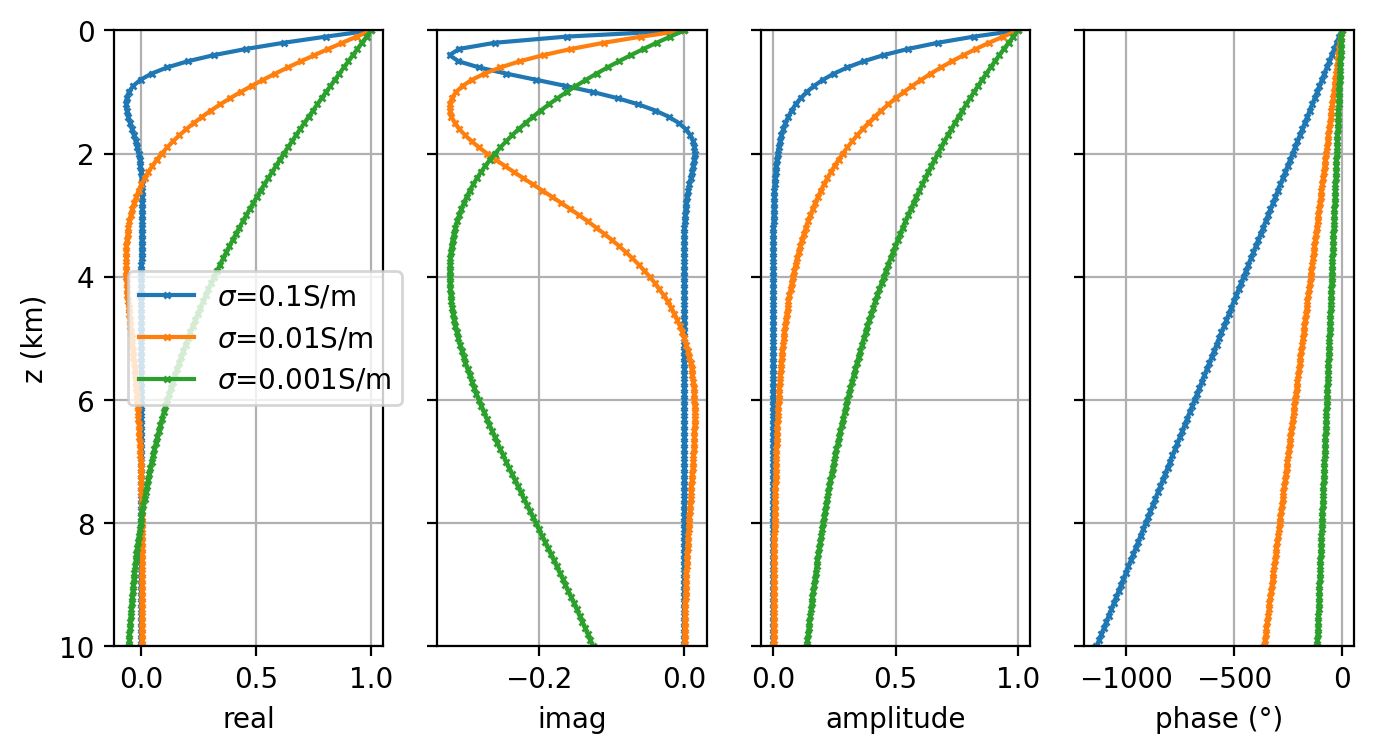

In [5]:
ax = showResult(z, analyticalSolutionH(z, 0.1), label=r"$\sigma$=0.1S/m")
showResult(z, analyticalSolutionH(z, 0.01), label=r"$\sigma$=0.01S/m", ax=ax)
showResult(z, analyticalSolutionH(z, 0.001), label=r"$\sigma$=0.001S/m", ax=ax)
ax[0].legend();

In [6]:
sigma = np.ones(len(z)-1) * sigma0
grid = pg.createGrid(z)
A = ps.createStiffnessMatrix(grid)
M = ps.createMassMatrix(grid, sigma*mu)

In [7]:
b = np.zeros(len(z))
ps.assembleDirichletBC(A, [[grid.boundary(1), 1]], b)
M.cleanRow(0)
C = pg.core.CSparseMatrix(A.vecColPtr(), A.vecRowIdx(), 
                          pg.core.toComplex(A.vecVals(), M.vecVals()*w))
c = pg.core.toComplex(b, b*0)
u = ps.linSolve(C, c)

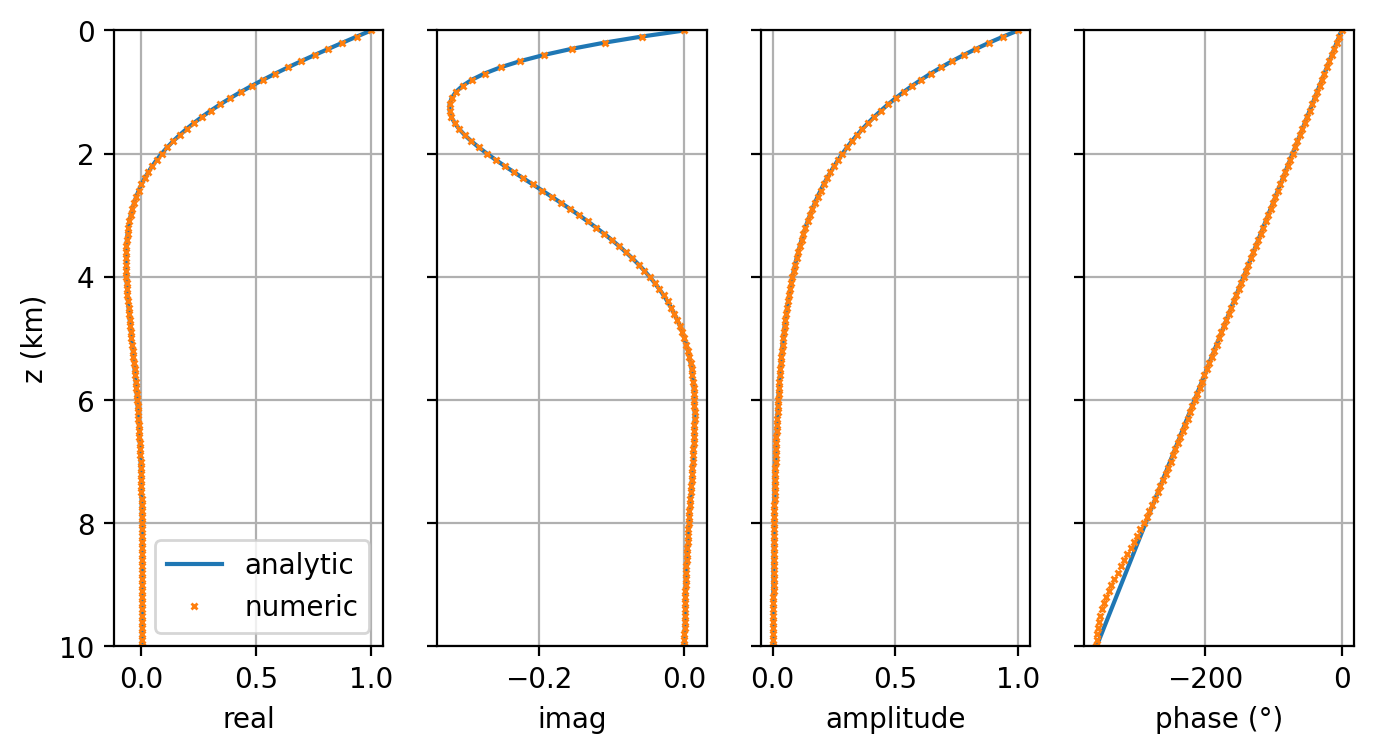

In [8]:
uAna = analyticalSolutionH(z, sigma0)
ax = showResult(z, uAna, label="analytic", marker="");
ax = showResult(z, u, ax=ax, label="numeric", ls="");
ax[0].legend();

Another way is to transform the complex problem 
$$(\bf A+\imath\omega\bf M) \bf u=\bf b$$
into a real-valued one:
$$ \begin{bmatrix} \bf A & -\omega\bf M\\ \omega\bf M & \bf A \end{bmatrix}
\begin{bmatrix} \bf u_R \\ \bf u_I \end{bmatrix} 
= \begin{bmatrix} \bf b_R \\ \bf b_I \end{bmatrix}
$$

In [9]:
ndof = A.rows()
B = pg.BlockMatrix()
B.Aid = B.addMatrix(A)
B.Mid = B.addMatrix(M)
B.addMatrixEntry(B.Aid, 0, 0)
B.addMatrixEntry(B.Aid, ndof, ndof)
B.addMatrixEntry(B.Mid, 0, ndof, scale=-w)
B.addMatrixEntry(B.Mid, ndof, 0, scale=w)
D = B.sparseMapMatrix()
d = np.hstack([b, b*0])
uRI = ps.linSolve(D, d)  # which solver is used for a block matrix? must be iterative

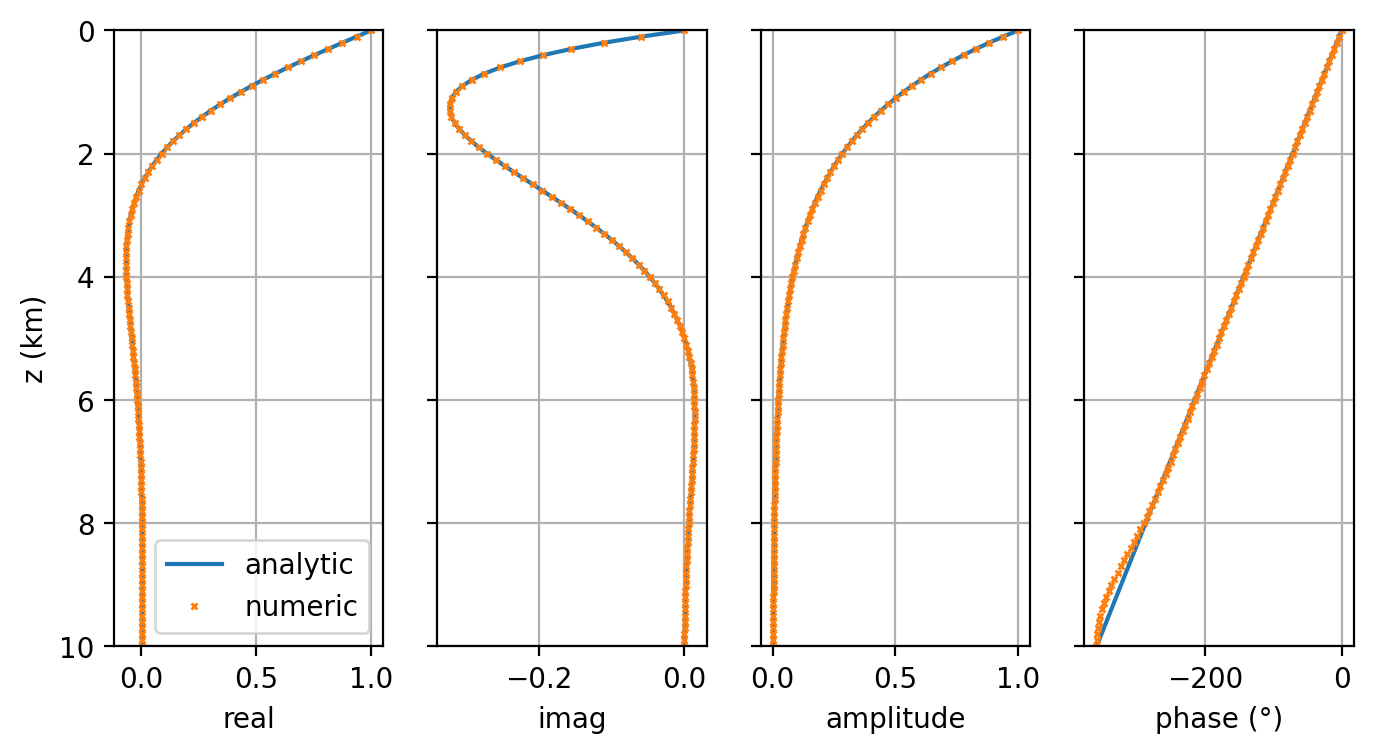

In [10]:
u2 = uRI[:len(uRI)//2].array() + uRI[len(uRI)//2:].array() * 1j
ax = showResult(z, uAna, label="analytic", marker="");
ax = showResult(z, u2, ax=ax, label="numeric", ls="");
ax[0].legend();

## Inhomogeneous conductivity

In [11]:
sigma = np.ones(len(z)-1) * sigma0
sigma[30:40] *= 10
zlmin = z[min(np.nonzero(sigma>sigma0)[0])]
zlmax = z[max(np.nonzero(sigma>sigma0)[0])+1]

In [12]:
A = ps.createStiffnessMatrix(grid)
M = ps.createMassMatrix(grid, sigma*mu)
b = np.zeros(len(z))
ps.assembleDirichletBC(A, [[grid.boundary(1), 1]], b)
M.cleanRow(0)
C = pg.core.CSparseMatrix(A.vecColPtr(), A.vecRowIdx(), 
                          pg.core.toComplex(A.vecVals(), M.vecVals()*w))
c = pg.core.toComplex(b, b*0)
u = ps.linSolve(C, c).array()

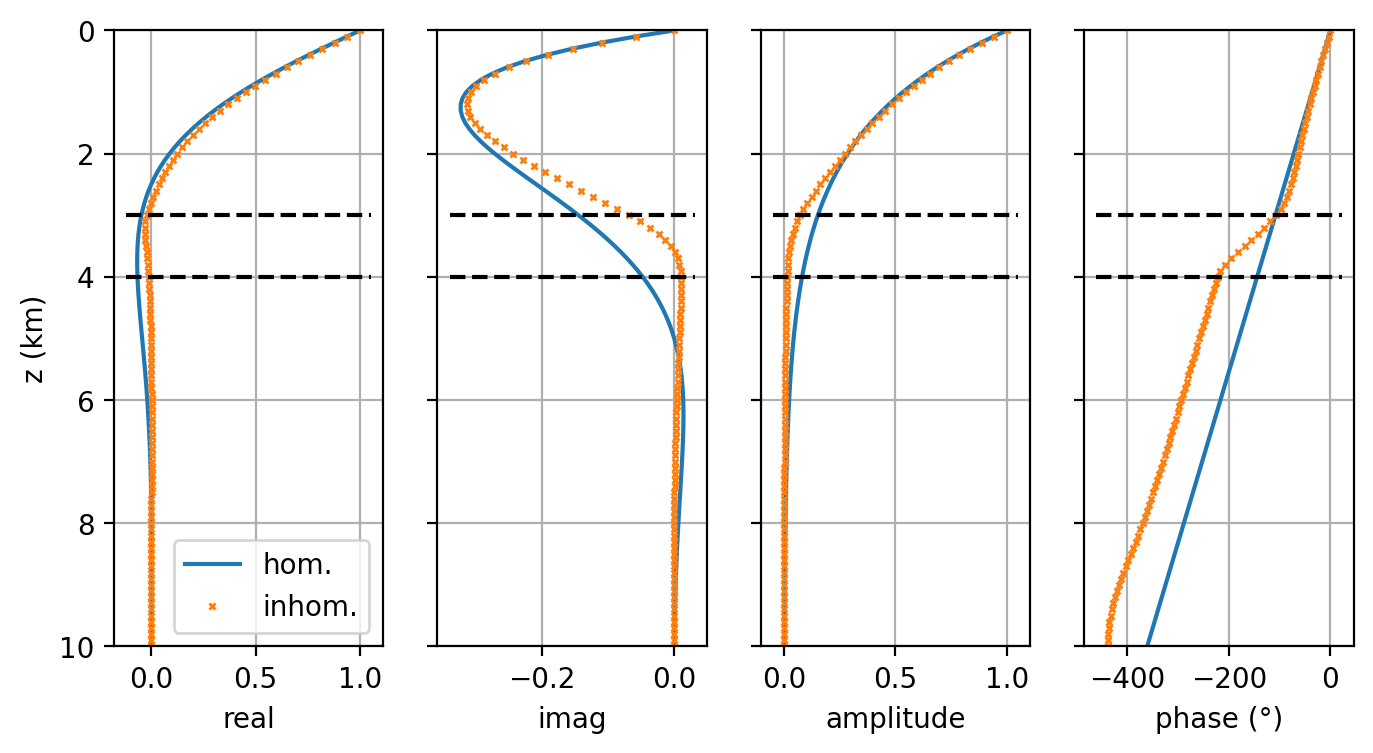

In [13]:
ax = showResult(z, uAna, label="hom.", marker="");
ax = showResult(z, u, ax=ax, zl=[zlmin, zlmax], label="inhom.", ls="");
ax[0].legend(loc="best");

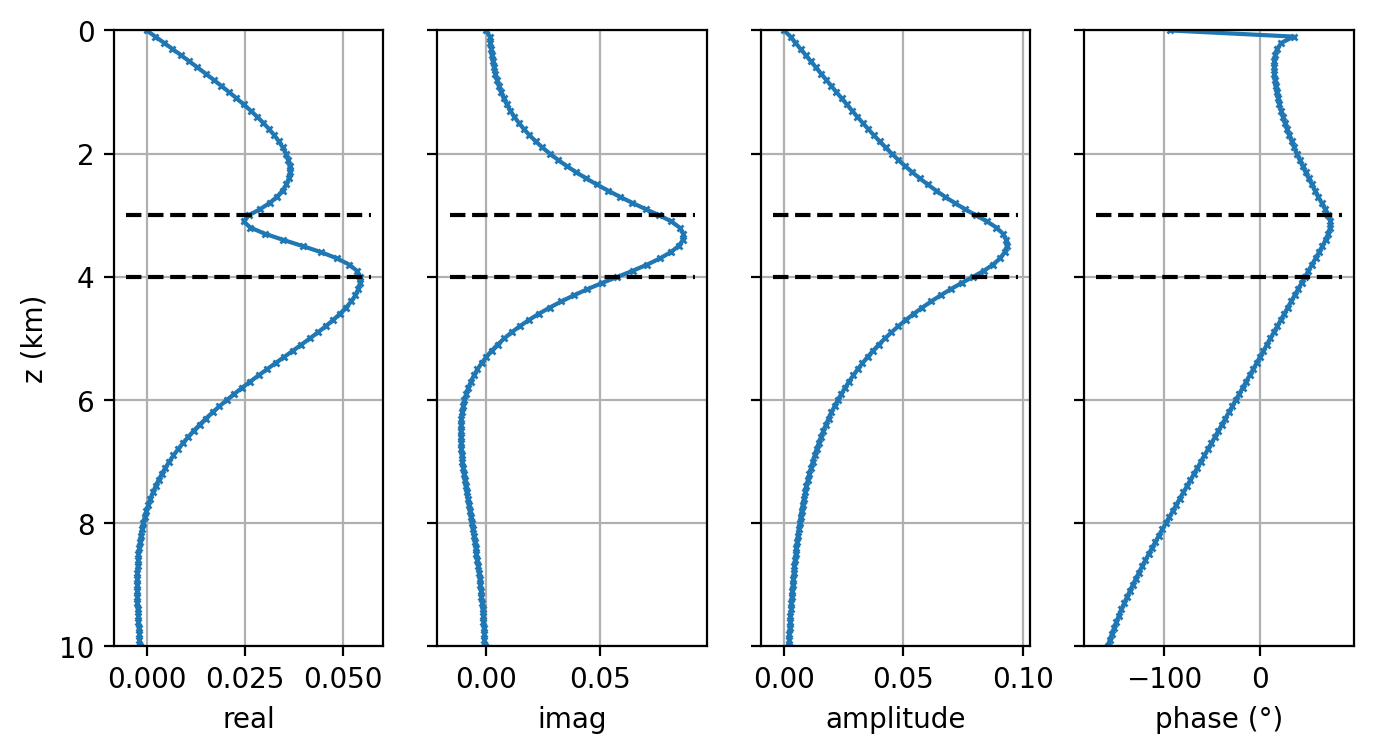

In [14]:
showResult(z, u-uAna, zl=[zlmin, zlmax]);

## Secondary field

In [15]:
Md = ps.createMassMatrix(grid, (sigma-sigma0)*mu)
rhs = -pg.core.toComplex(Md.dot(uAna.real), Md.dot(uAna.imag)) * w * 1j

In [16]:
uS = ps.linSolve(C, rhs)

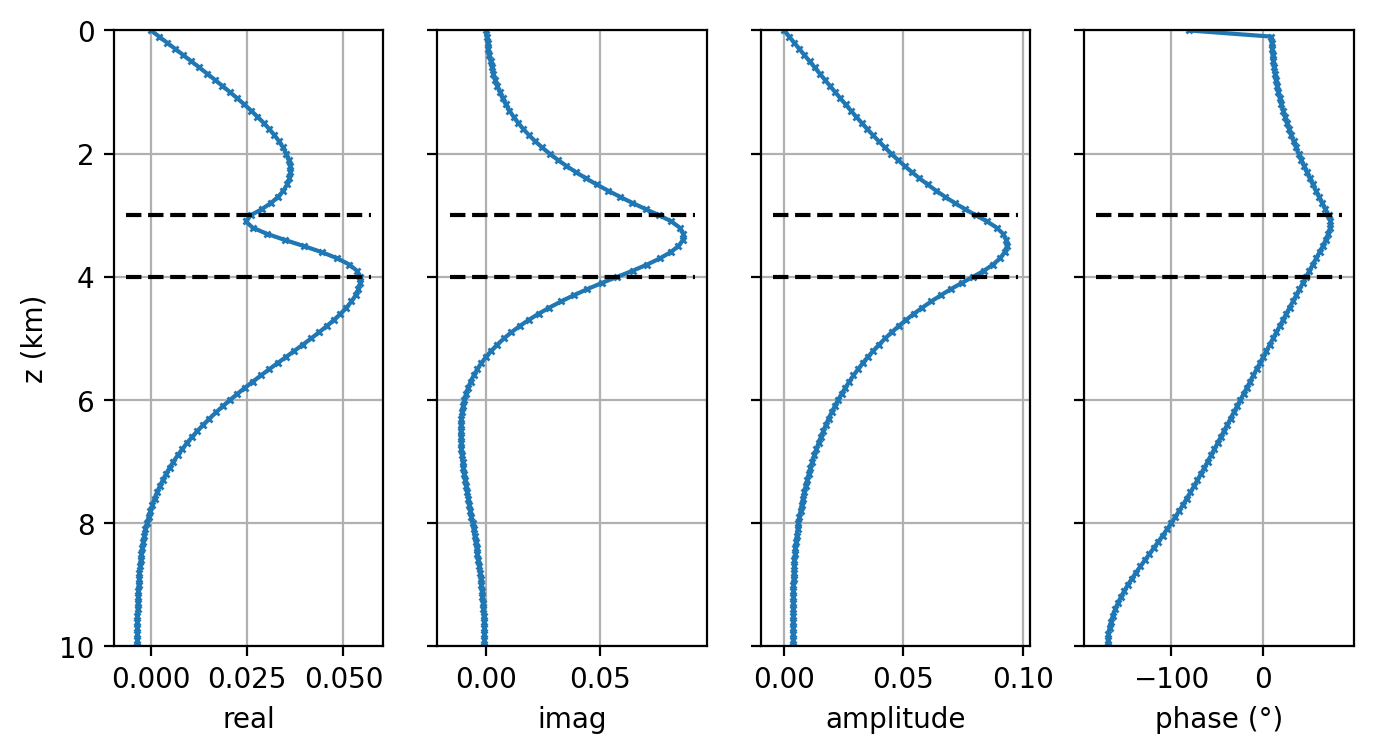

In [17]:
showResult(z, uS, zl=[zlmin, zlmax], label="secondary field");

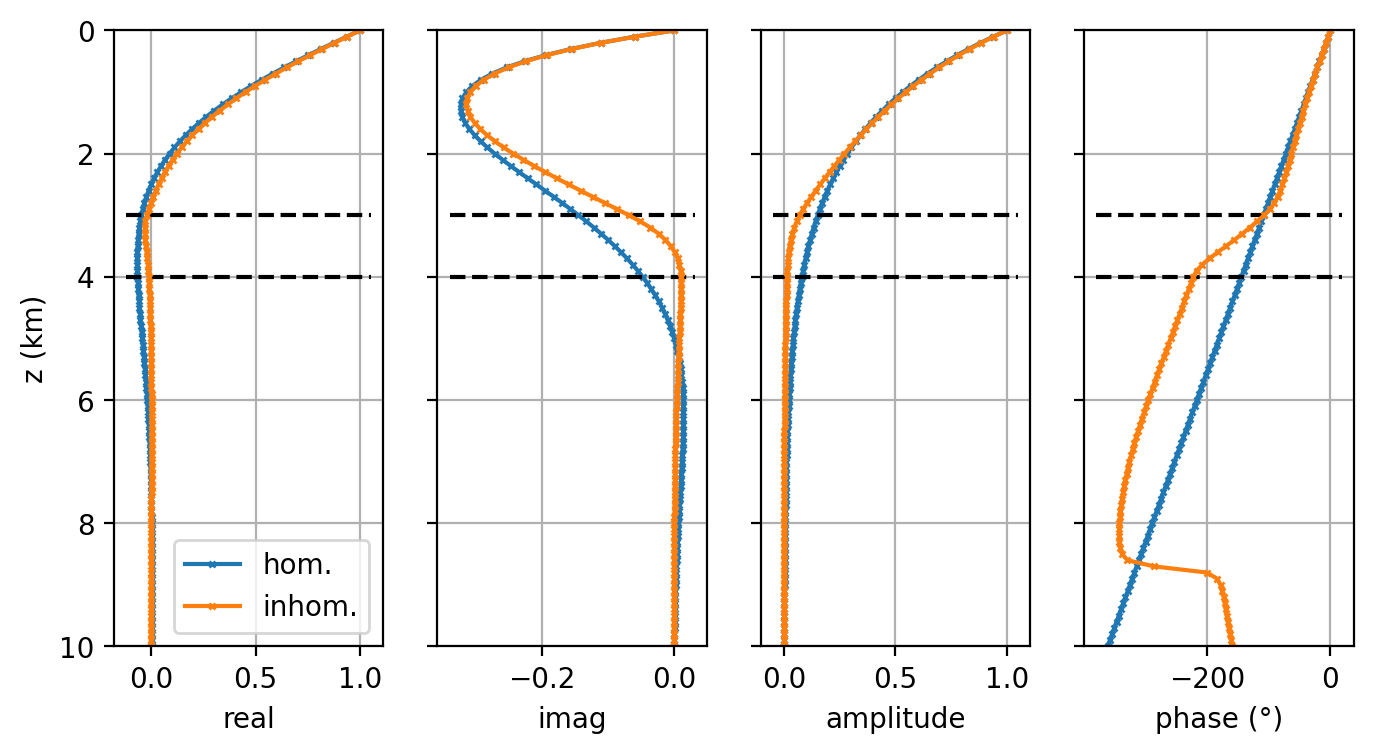

In [18]:
ax = showResult(z, uAna, label="hom.", zl=[zlmin, zlmax]);
showResult(z, uAna+uS, label="inhom.", ax=ax)
ax[0].legend();

In [19]:
ndof = A.rows()
B = pg.BlockMatrix()
B.Aid = B.addMatrix(A)
B.Mid = B.addMatrix(M)
B.addMatrixEntry(B.Aid, 0, 0)
B.addMatrixEntry(B.Aid, ndof, ndof)
B.addMatrixEntry(B.Mid, 0, ndof, scale=-w)
B.addMatrixEntry(B.Mid, ndof, 0, scale=w)
D = B.sparseMapMatrix()

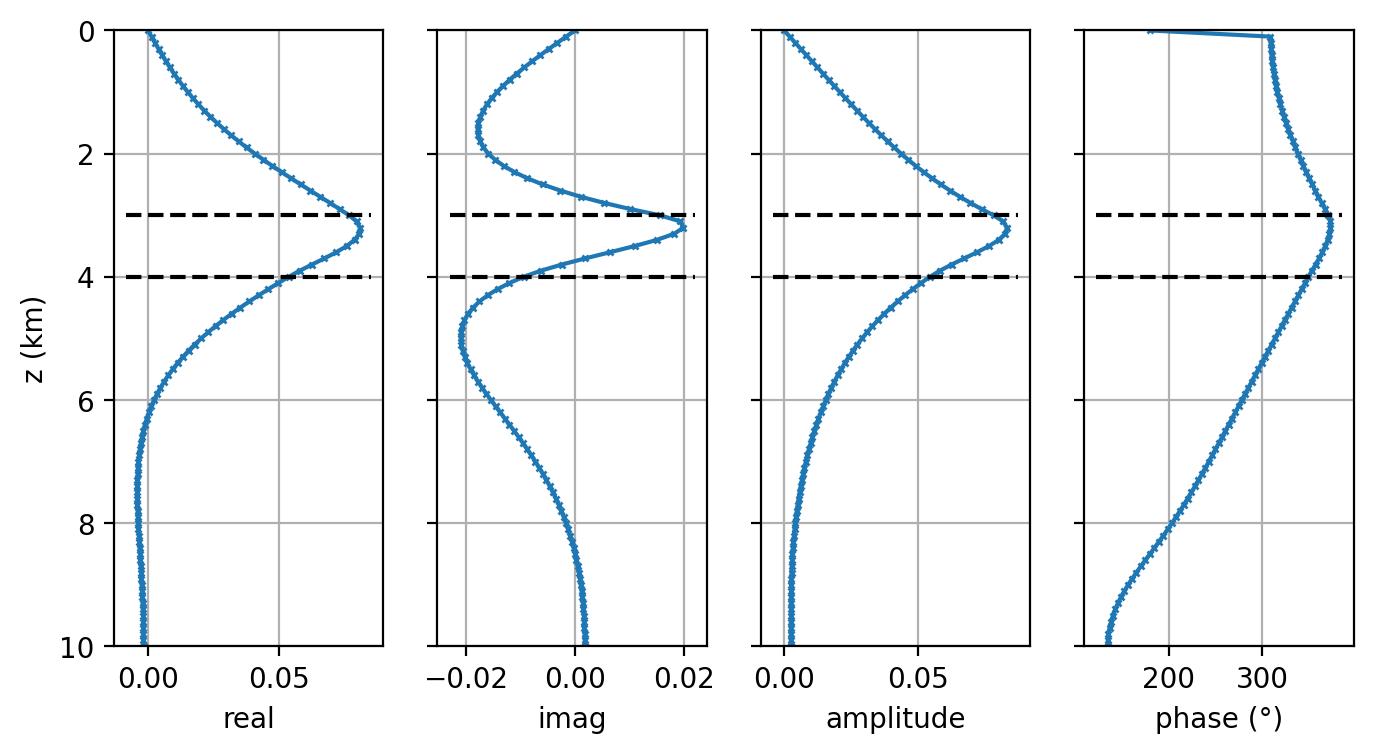

In [20]:
d = -np.hstack([Md.dot(uAna.real),  Md.dot(uAna.imag) * w])
uSRI = ps.linSolve(D, d)
uS = uSRI[:len(uSRI)//2].array() + uSRI[len(uSRI)//2:].array() * 1j
showResult(z, uS, zl=[zlmin, zlmax]);